## COVID-19 Projection of an Average State Under No Intervention Measures
### By: Tinh Son

***2020-04-08***

- Currently looking at the dataset and trying to pipline the stats extraction process. 
- Data source is from folder ./csse_covid19_daily_reports, source: [Github](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports)
- Trying to work on spatial visualization on plt. More progress will be made next week.

**2020-04-15**

- Background image projection issue, had to install basemap package via the following instruction:
```
sudo apt-get install proj-bin
sudo apt-get install libgeos-dev
sudo pip3 install --user https://github.com/matplotlib/basemap/archive/master.zip
```
- Worked on mapPlot method and generated US maps for all available dates.
- Attempted stitching graphs together.

**2020-04-17**

- Fixed Map Scalings

***2020-04-21***

- Investigating SIR Model and attempting to integrate.

- Creating an interactive model and trying to understand the model parameters with respect to interaction term.


***2020-04-22***

- Editted SIRD model to include delay. Still need to explore intervention terms $\omega$.

- Created UI for exploring model through various parameters. 

- Organized data based on states and dates. Planning to graph all progressions.

- Next step is to use processed states data to fit parameter values from the model to each state, then attempt projection. Thinking of using a coxcomb diagram.

***2020-04-24***

Many things were realized during this work session:

- I'm using _pymcmcstat_ for parameter estimation. Commands are pretty verbose and tiring, the plus side is that defining cost functions and appropriate parameter settings are pretty easy. 

- With my current skillset, I'm unable to perform parameter estimation of SIR for each state. So the plan has been changed to finding one single parameter settings for ONE hypothetical state:
    - This state has an average population of 6 millions.
    
- MCMC parameterization is based **solely** on the confirmed cases. This is aggregated as scatterplot of each state from all date, simulating the data needing to be "fitted".

- MCMC simulation takes an average of **15 minutes** to run. 

**Initial Conditions of projection**

- Basic state projection has an average population of about 6 millions (US pop / 50 states)

- Susceptible population is the average population - (latest confirmed number  / 50 states) - latest removed 

- Removed is sum of (current recovered + current deaths) / 50 states

- This projection assumes **ABSOLUTELY NO INTERVENTION MEASURES WERE ENFORCED**.

**Both MCMC simulation and projection assume a 14 days incubation period**.

***2020-04-27***

- Refactor into python script.

- Automate data download using gitdir.

**2020-04-29**

Spreadsheets before 10th of March combined locality with states, therefore affected the output of self.states. This problem is fixed with several lines of codes in statesBreakdown method. 
"Recovered" columns after March 10th has no values. This is something the data-collection side needs to fix.

### This section of code is for data manipulation and visualization.

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from cycler import cycler

from datetime import datetime as dt
import os
import glob
import re
from mpl_toolkits.basemap import Basemap
from itertools import product as prod

import gitdir
import subprocess
# from jupyterthemes import jtplot
# jtplot.style(theme = 'onedork')

'''plot settings'''
# sns.set_style("ticks")
sns.set_context(font_scale = 1, rc = {"lines.linewidth": 2.0, 'lines.markersize': 5})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
mpl.rc('axes', prop_cycle = (cycler('color', ['r', 'k', 'b','g','y','m','c','gray']) ))
mpl.rc('text', usetex = False)
tw = 1.5
sns.set_style({"xtick.major.size": 6, "ytick.major.size": 6,
               "xtick.minor.size": 4, "ytick.minor.size": 4,
               'axes.labelsize': 24,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})
mpl.rc('xtick', labelsize = 18)
mpl.rc('ytick', labelsize = 18)
mpl.rc('axes', linewidth = 1.75)
sns.set_style({'axes.labelsize': 24, 'axes.titlesize': 24})

##################################################


In [23]:
class preProcess():
    def __init__(self, path, country):
        self.__dates = sorted([re.search(r'(\d+-\d+-\d+)', d).group() for d in glob.glob(os.path.join(path, "*.csv"))])
        self.__df = {re.search(r'(\d+-\d+-\d+)',i).group(): pd.read_csv(i) for i in glob.glob(os.path.join(path, "*.csv"))}
        self.c_format = {'Country/Region', 'Country_Region'} #Upon looking at csv formats, I realized there is an inconsistency in keys. This should fix it.
        self.coords_format = {'Latitude', 'Longitude', 'Lat', 'Long_'}
        self.s_format = {'Province/State', 'Province_State'}
        self.__countries = sorted({country for d in self.__dates for country in self.__df[d][(self.c_format & set(self.__df[d].columns)).pop()]})
        
        #1
        self.__cDates = sorted({i for i in self.dates if country in set(self.df[i][(self.c_format & set(self.df[i].columns)).pop()])} &
                               {j for j in self.dates if len(set(self.df[j][(self.coords_format & set(self.df[j].columns))]))})

        #2
        self.__country = self.countryBreakDown(country)
        
        #3 
        self.__states = self.statesBreakDown()
        #the extend of data cleaning...
    
    @property
    def dates(self):
        return self.__dates
    
    @property
    def df(self):
        return self.__df
    
    @property
    def countries(self):
        return self.__countries
    
    @property
    def country(self):
        return self.__country
    
    @property 
    def cDates(self):
        return self.__cDates
    
    @property
    def states(self):
        return self.__states

    def extractStats(self, date):
        return self.df[date].groupby((self.c_format & set(self.df[date].columns)).pop())[['Confirmed', 'Recovered', 'Deaths']].sum()

    def statsPerCountry(self, country):
        avail = sorted({i for i in self.dates if country in set(self.df[i][(self.c_format & set(self.df[i].columns)).pop()])})
        stats = pd.DataFrame(map(lambda x: np.array(self.extractStats(x).loc[country]), avail), 
                             columns = ['Confirmed', 'Recovered', 'Deaths'], 
                             index = avail)
        stats.index.name = 'Dates'
        return stats
    
    #Break down stats by State/Province
    def countryBreakDown(self, country):
        #Data processing is getting more difficult than I though. Let's hope that they stop changing the data format as the day goes on.
        pre_df = {d: self.df[d][self.df[d][(self.c_format & set(self.df[d].columns)).pop()] == country][[(self.s_format & set(self.df[d].columns)).pop(), 
                                           sorted(self.coords_format & set(self.df[d].columns))[-1],
                                           sorted(self.coords_format & set(self.df[d].columns))[0], 
                                           'Confirmed', 'Recovered', 'Deaths']].set_index((self.s_format & set(self.df[d].columns)).pop()) for d in self.cDates}
        #Add multi-Index
        for k, v in pre_df.items():
            coords = list(prod(['Coordinates'], v.columns[:2]))
            coords.extend(list(prod([k], v.columns[2:])))
            v.columns = pd.MultiIndex.from_tuples(coords)
            v.index.names = ['State/Province'] #Rename index level for consistency
        return pre_df
        
    #Statesbreak down. PASS IN self.country
    def statesBreakDown(self):
        statesdict = {"D.C":"District of Columbia","AL":"Alabama","AK":"Alaska","AZ":"Arizona","AR":"Arkansas","CA":"California","CO":"Colorado","CT":"Connecticut","DE":"Delaware","FL":"Florida","GA":"Georgia","HI":"Hawaii","ID":"Idaho","IL":"Illinois","IN":"Indiana","IA":"Iowa","KS":"Kansas","KY":"Kentucky","LA":"Louisiana","ME":"Maine","MD":"Maryland","MA":"Massachusetts","MI":"Michigan","MN":"Minnesota","MS":"Mississippi","MO":"Missouri","MT":"Montana","NE":"Nebraska","NV":"Nevada","NH":"New Hampshire","NJ":"New Jersey","NM":"New Mexico","NY":"New York","NC":"North Carolina","ND":"North Dakota","OH":"Ohio","OK":"Oklahoma","OR":"Oregon","PA":"Pennsylvania","RI":"Rhode Island","SC":"South Carolina","SD":"South Dakota","TN":"Tennessee","TX":"Texas","UT":"Utah","VT":"Vermont","VA":"Virginia","WA":"Washington","WV":"West Virginia","WI":"Wisconsin","WY":"Wyoming"}
        DPfilter = {'Unassigned Location (From Diamond Princess)','Grand Princess Cruise Ship'} 
        #Use latest date as scheme for merge. This relies heavily on the latest date contains coords
        latest = self.cDates[-1]
        dff = self.country[latest].groupby(self.country[latest].index).sum()
        dff.drop(columns = dff.columns.levels[0][0], level = 0, inplace = True) #Drop the date columns, so all we have now are the states
        if len(dff.columns.levels) == 2:
            dff.drop(columns = dff.columns.levels[0][1], level = 0, inplace = True) #DROPPING COORDINATES TOO. COMMENT IF NEEDED
        #####################################################################
        for i in self.cDates:
            df = self.country[i].groupby(self.country[i].index).sum()
            #Some dates do not have the coordinates column, Need to check length of level 0 multiIndex
            if len(df.columns.levels) == 2:
                df.drop(columns = df.columns.levels[0][1], level = 0, inplace = True)
            #before merging, filter state/province columns from previous dates
            if len(set(df.index) & DPfilter):
                df.drop(index = list(set(df.index) & DPfilter), inplace = True)
            filtered = [re.findall(r'([A-Z]{2}|[A\.-Z]{3})', x)[0] for x in df.index if len(re.findall(r'([A-Z]{2}|[A\.-Z]{3})', x)) == 1] 
            if len(set(statesdict) & set(filtered)):
                df.index = [statesdict[s] for s in filtered]
                df = df.groupby(df.index).sum()
                df.index.names = ['State/Province']
            dff = pd.merge(dff, df, how = 'left', on = 'State/Province')
        #Depending on new locations, might need to add or remove from below
        dff.drop(index = ['Recovered','Virgin Islands', 'Northern Mariana Islands', 'Grand Princess', 'Diamond Princess', 'Puerto Rico'], inplace = True)
        dff.fillna(0, inplace = True) #Fill na for states whose values don't exist from previous dates
        return dff
    
    def getStats(self, state):
        s = pd.DataFrame(self.states.loc[state]).transpose()
        c = list(map(lambda x: s[x]['Confirmed'].values[0], self.cDates))
        r = list(map(lambda x: s[x]['Recovered'].values[0], self.cDates))
        d = list(map(lambda x: s[x]['Deaths'].values[0], self.cDates))
        return (c, r, d)
    
    #Graphs stats for states: REQUIRES dff
    def statesGraph(self, state):
        fig, ax = plt.subplots(1, figsize = (15, 12))
        c, r, d = self.getStats(state)
        ax.plot(self.cDates, c, label = 'Confirmed')
        ax.plot(self.cDates, r, label = 'Recovered')
        ax.plot(self.cDates, d, label = 'Deaths')
#         ax.grid(b = None)
        ax.set_xticks(self.cDates[::5])
        ax.set_xticklabels(self.cDates[::5], rotation = 45)
        ax.legend()
        plt.title(state)
        
    #Valid columns are: 'Confirmed', 'Recovered', 'Deaths'
    def barGraphPerCountry(self, c_frame, column):
        fig, ax = plt.subplots(figsize = (12, 6))    
        fig = sns.barplot(x = list(c_frame.index), 
                          y = column, 
                          data = c_frame,
                          orient = 'v')
        ax.set_xticklabels([])
        
    def mapPlot(self, c_frame, column, save = 1):
        date = c_frame.columns.levels[0][0]
        cf = c_frame.copy(deep = True)
        cf.columns = cf.columns.droplevel(0)
        #Filter coordinates from US cases outside mainland (excluding Alaska)
        cf = cf[(cf[cf.columns[0]].between(-130, -55) & cf[cf.columns[1]].between(26, 50))]
        
        
        '''Bookkeeping'''
        lon, lat = cf[cf.columns[0]].values, cf[cf.columns[1]].values
        confirmed, color = cf['Confirmed'].values, cf[column].values 
        max_col = self.country[self.cDates[-1]][self.cDates[-1]][column].values
        
        '''Draw map'''
        fig = plt.figure(figsize = (20, 20))
        m = Basemap(projection = 'lcc', resolution = 'l',
            width = 5E6, height = 4E6, 
            lat_1 = 26., lat_2 = 50, lat_0 = 35, lon_0 = -98)
        m.shadedrelief()
        m.drawcoastlines(color = 'gray')
        m.drawcountries(color = 'black')
        m.drawstates(color = 'gray')
        
        '''Scatter'''
        cNorm = plt.Normalize(vmin = 0, vmax = max_col.max())
        m.scatter(x = lon, y = lat, latlon = True,
                  s = confirmed,
                  c = color, cmap = plt.get_cmap('jet'),
                  norm = cNorm,
                  alpha = 0.5)
    
        cbar = plt.colorbar(label = column, shrink = 0.60)    
        
        plt.ylabel('Latitude', fontsize = 14)
        plt.xlabel('Longitude', fontsize = 14)
        plt.title('Confirmed Cases for {}: {}'.format(date, int(confirmed.sum())), fontsize = 20)
        
        #Size legend
        for a in [10, 100, 500]:
            plt.scatter([], [], c = 'k', alpha = 0.9, s = a,
                        label = str(a) + ' Confirmed')
        plt.legend(loc = 3, fontsize = 16)
        
        if not save:
            plt.show()
            
        else:
            if not os.path.exists('Progress'):
                os.makedirs('Progress')
            plt.savefig("Progress/{}.png".format(date), bbox_inches = 'tight', dpi = 100)
            plt.clf()
            plt.close()

        
#########################################################################
# pd.set_option('max_columns', None)
# pd.set_option('max_rows', None)
# subprocess.run(['gitdir', 'https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports/']) #comment the line below if you have not downloaded the data
directory = './csse_covid_19_data/csse_covid_19_daily_reports'
pre = preProcess(directory, 'US')
# print('Countries: {} \n'.format(pre.countries))
# print('Dates in df: {} \n'.format(pre.dates))

# pre.mapPlot(pre.country[pre.cDates[0]], 'Deaths', 0)
# pre.mapPlot(pre.country[pre.cDates[-1]], 'Deaths', 0)

               03-01-2020                 
                Confirmed Recovered Deaths
State/Province                            
Arizona                 1         1      0
California             12         2      0
Illinois                3         2      0
Massachusetts           1         1      0
Nebraska                0         0      0
Oregon                  1         0      0
Rhode Island            1         0      0
Texas                   1         0      0
Washington             11         1      1
Wisconsin               1         0      0
               03-02-2020                 
                Confirmed Recovered Deaths
State/Province                            
Arizona                 1         1      0
California             21         2      0
Florida                 2         0      0
Illinois                4         2      0
Massachusetts           1         1      0
Nebraska                0         0      0
New Hampshire           1         0      0
New York   

                         03-23-2020                 
                          Confirmed Recovered Deaths
State/Province                                      
Alabama                         196         0      0
Alaska                           30         0      0
American Samoa                    0         0      0
Arizona                         235         0      2
Arkansas                        192         0      0
California                     2108         0     39
Colorado                        704         0      7
Connecticut                     415         0     10
Delaware                         68         0      0
Diamond Princess                 49         0      0
District of Columbia            120         0      2
Florida                        1227         0     18
Georgia                         772         0     25
Grand Princess                   28         0      1
Guam                             29         0      1
Hawaii                           56         0 

                         04-13-2020                 
                          Confirmed Recovered Deaths
State/Province                                      
Alabama                        3734         0     99
Alaska                          277         0      8
Arizona                        3705         0    122
Arkansas                       1410         0     29
California                    23931         0    714
Colorado                       7691         0    306
Connecticut                   13381         0    602
Delaware                       1758         0     41
Diamond Princess                 49         0      0
District of Columbia           1955         0     52
Florida                       21019         0    499
Georgia                       13315         0    465
Grand Princess                  103         0      0
Guam                            133         0      5
Hawaii                          504         0      9
Idaho                          1426         0 

In [24]:
pre.states

03-01-2020                  03-02-2020                   \
                      Confirmed Recovered Deaths  Confirmed Recovered Deaths   
State/Province                                                                 
Alabama                     0.0       0.0    0.0        0.0       0.0    0.0   
Alaska                      0.0       0.0    0.0        0.0       0.0    0.0   
Arizona                     1.0       1.0    0.0        1.0       1.0    0.0   
Arkansas                    0.0       0.0    0.0        0.0       0.0    0.0   
California                 12.0       2.0    0.0       21.0       2.0    0.0   
Colorado                    0.0       0.0    0.0        0.0       0.0    0.0   
Connecticut                 0.0       0.0    0.0        0.0       0.0    0.0   
Delaware                    0.0       0.0    0.0        0.0       0.0    0.0   
District of Columbia        0.0       0.0    0.0        0.0       0.0    0.0   
Florida                     0.0       0.0    0.0        2.0       0.0    0.0   
Georgia                     0.0       0.0    0.0        0.0       0.0    0.0   
Guam                        0.0       0.0    0.0        0.0       0.0    0.0   
Hawaii                      0.0       0.0    0.0        0.0       0.0    0.0   
Idaho                       0.0       0.0    0.0        0.0       0.0    0.0   
Illinois                    3.0       2.0    0.0        4.0       2.0    0.0   
Indiana                     0.0       0.0    0.0        0.0       0.0    0.0   
Iowa                        0.0       0.0    0.0        0.0       0.0    0.0   
Kansas                      0.0       0.0    0.0        0.0       0.0    0.0   
Kentucky                    0.0       0.0    0.0        0.0       0.0    0.0   
Louisiana                   0.0       0.0    0.0        0.0       0.0    0.0   
Maine                       0.0       0.0    0.0        0.0       0.0    0.0   
Maryland                    0.0       0.0    0.0        0.0       0.0    0.0   
Massachusetts               1.0       1.0    0.0        1.0       1.0    0.0   
Michigan                    0.0       0.0    0.0        0.0       0.0    0.0   
Minnesota                   0.0       0.0    0.0        0.0       0.0    0.0   
Mississippi                 0.0       0.0    0.0        0.0       0.0    0.0   
Missouri                    0.0       0.0    0.0        0.0       0.0    0.0   
Montana                     0.0       0.0    0.0        0.0       0.0    0.0   
Nebraska                    0.0       0.0    0.0        0.0       0.0    0.0   
Nevada                      0.0       0.0    0.0        0.0       0.0    0.0   
New Hampshire               0.0       0.0    0.0        1.0       0.0    0.0   
New Jersey                  0.0       0.0    0.0        0.0       0.0    0.0   
New Mexico                  0.0       0.0    0.0        0.0       0.0    0.0   
New York                    0.0       0.0    0.0        1.0       0.0    0.0   
North Carolina              0.0       0.0    0.0        0.0       0.0    0.0   
North Dakota                0.0       0.0    0.0        0.0       0.0    0.0   
Ohio                        0.0       0.0    0.0        0.0       0.0    0.0   
Oklahoma                    0.0       0.0    0.0        0.0       0.0    0.0   
Oregon                      1.0       0.0    0.0        3.0       0.0    0.0   
Pennsylvania                0.0       0.0    0.0        0.0       0.0    0.0   
Rhode Island                1.0       0.0    0.0        2.0       0.0    0.0   
South Carolina              0.0       0.0    0.0        0.0       0.0    0.0   
South Dakota                0.0       0.0    0.0        0.0       0.0    0.0   
Tennessee                   0.0       0.0    0.0        0.0       0.0    0.0   
Texas                       1.0       0.0    0.0        1.0       0.0    0.0   
Utah                        0.0       0.0    0.0        0.0       0.0    0.0   
Vermont                     0.0       0.0    0.0        0.0       0.0    0.0   
Virginia             

Scaling looks consistent from first date to last date. Next step to process all dates and stitch into a video.

In [ ]:
#Will take a while 
#Create maps for all dates
mpl.use('Agg')
for i, date in enumerate(pre.country.keys()):
    print("Creating map for {}.........{}/{}".format(date, i + 1, len(pre.country.keys())))
    pre.mapPlot(pre.country[date], 'Deaths', 1)
print('Done.')

In [ ]:
cd Progress/

Received the code below from [here](https://theailearner.com/2018/10/15/creating-video-from-images-using-opencv-python/)

In [ ]:
import cv2
#Writes images to video.  
path = sorted(glob.glob(os.path.join('./*.png')))
files = [cv2.imread(file) for file in path]
height, width, layers = files[0].shape
size = (width, height)
files = [cv2.resize(file, size) for file in files]

out = cv2.VideoWriter('US60.avi', cv2.VideoWriter_fourcc(*'XVID'), 60, size) 
for file in files:
    for _ in range(15):
        out.write(file)
out.release()

Looking at the video, notice a shift in scatter plot from 21st of March to 22nd of March. This indicates the progression in data collection, where cases are now more granular instead of aggregated state-only. 

### Looking at possible models

### SIR

**SIR** stands for "Susceptible, Infected, Removed", following a sequential scheme of $S \rightarrow I \rightarrow R$:

1. $$\frac{dS}{dt} = - \frac{\beta S I}{N}$$

1. $$\frac{dI}{dt} =   \frac{\beta S I}{N} - \gamma I$$

1. $$\frac{dR}{dt} = \gamma I$$

1. $$R_0 = \frac{\beta}{\gamma}$$

Where:

- $\beta$ is the infection rate

- $\gamma$ is the removed rate

- $N$ is the total population

- $R_0$ is the basic reproduction rate

This model assumes that the entire population is equally likely to get infected (ignore age). Notice the system unit is in fraction of population.

I want to explore the possibility of including delay to represent incubation period, thus:

1. $$\frac{dS}{dt} = - \frac{\beta S_\tau I_\tau}{N}$$

1. $$\frac{dI}{dt} =  \frac{\beta  S I}{N} - \gamma I$$

1. $$\frac{dR}{dt} = \gamma I$$

1. $$R_0 = \frac{\beta}{\gamma}$$

- $\tau$ is the delay constant from incubation period to infection: $S(t) = S,\ S(t - \tau) = S_\tau...$ and so on.
One main assumption is that the total population remains constant, such that $S + I + R = N$. Also notice that the initial number of infected must be $\ge 1$ for there to be any movement at all. For the model, Recovered + Deaths is combined to R to facilitate MCMC process. 


In [5]:
#New package for integration
from scipy.integrate import odeint

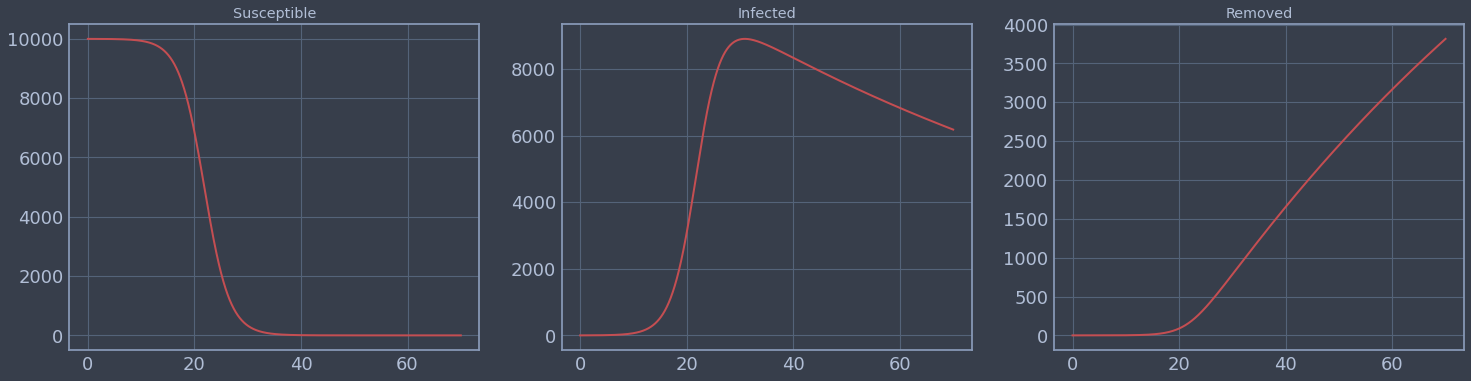

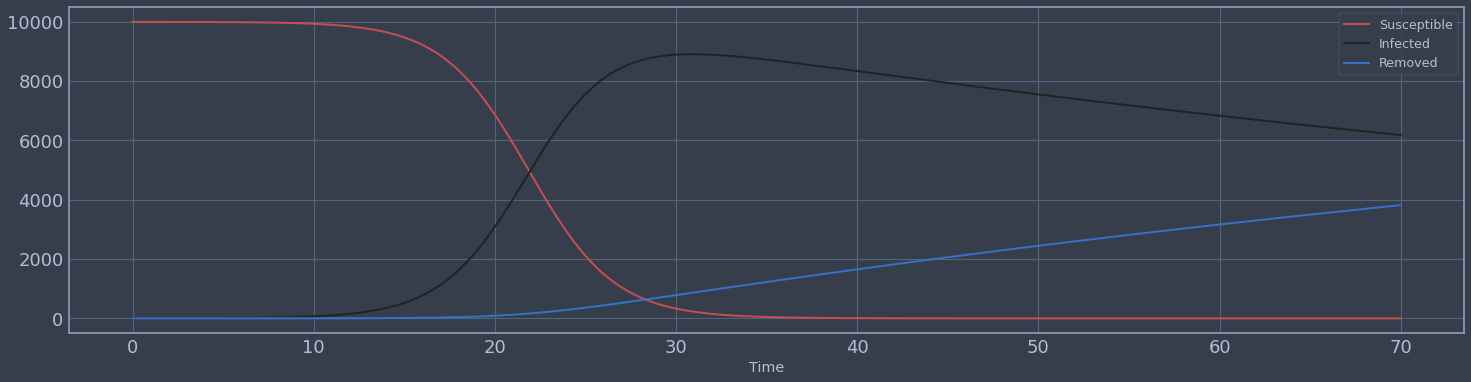

In [6]:
#Initial integration
class SIR:
    def __init__(self, t, delay): #parameter values declared when run model
        self.__beta = 1
        self.__gamma = 1
        self.__R = beta/gamma 
        self.__N = 1
        ##Delay value for Susceptible to be included in the model
        self.__steps = []
        self.__t = t
        self.__delay = delay
        
    @property
    def beta(self):
        return self.__beta
    @beta.setter
    def beta(self, val):
        self.__beta = val
        self.__R = self.beta/self.gamma 

    @property
    def gamma(self):
        return self.__gamma
    @gamma.setter
    def gamma(self, val):
        self.__gamma = val
        self.__R = self.beta/self.gamma 
        
    @property
    def N(self):
        return self.__N
    @N.setter
    def N(self, val):
        self.__N = val
        
    @property
    def steps(self):
        return self.__steps
    @steps.setter
    def steps(self, val):
        self.__steps = val
    
    @property 
    def t(self):
        return self.__t
    @t.setter
    def t(self, val):
        self.__t = val
        
    @property 
    def delay(self):
        return self.__delay
    @delay.setter
    def delay(self, val):
        self.__delay = val
        
    def __model(self, z, t, beta, gamma): 
        S, I, R = z[0], z[1], z[2]
        #Susceptible
        SDot = -(beta * (self.steps[(-1 - self.delay)%len(self.steps)][0] * self.steps[(-1 - self.delay)%len(self.steps)][1]))/self.N
        #Infected
        IDot = (beta * (S * I))/self.N - gamma * I 
        #Removed
        RDot = gamma * I
        #Dead
        dzdt = [SDot, IDot, RDot]
        return dzdt
                
    def runmodel(self, beta, gamma, N, S, I, R):
        self.beta, self.gamma, self.N = beta, gamma, N
        #initial conditions
        self.steps = []
        z0 = [S, I, R]
        self.steps.append(z0) #access previous calculation due to time delay
        
        sr = np.empty_like(self.t)
        ir = np.empty_like(self.t) 
        rr = np.empty_like(self.t)
        sr[0], ir[0], rr[0] = z0[0], z0[1], z0[2]
        
        #Integrate 
        for i in range(1, len(self.t), 1):
            tspan = [self.t[i -1], self.t[i]]
            z = odeint(self.__model, z0, tspan, args = (self.beta, self.gamma))
            sr[i] = z[1][0]
            ir[i] = z[1][1]
            rr[i] = z[1][2]
            z0 = z[1]
            #save values for DDE
            self.steps.append(z[1])
            
        results = np.array([sr, ir, rr])
        results[results < 0] = 0
        results[results > self.N] = self.N
        return results
    
##########################
beta = 0.431
gamma = 0.01
N = 10000
S = 9999
I = 1
R = 0
time = np.linspace(0, 70, 70*50)
test = SIR(time, 2)
results = test.runmodel(beta, gamma, N, S, I, R)

###########################
figr, axr = plt.subplots(nrows = 1, ncols = 3, figsize = (25, 6))
figc, axc = plt.subplots(nrows = 1, ncols = 1, figsize = (25, 6))
axr[0].plot(time, results[0])
axr[0].set(title = 'Susceptible')
axr[1].plot(time, results[1])
axr[1].set(title = 'Infected')
axr[2].plot(time, results[2])
axr[2].set(title = 'Removed')

'''Cumulative plot'''
axc.plot(time, results[0], label = 'Susceptible')
axc.plot(time, results[1], label = 'Infected')
axc.plot(time, results[2], label = 'Removed')
axc.legend()
axc.set(xlabel = 'Time')
plt.show()

In [7]:
#Create interactive graph to easily tweak parameters
from ipywidgets import interactive

def graphs(beta, gamma, t, delay, Details = False, Bifur = False):
    #Set initial conditions in here
    N = 6628664
    S = 6628663
    I = 1
    R = 0

    time = np.linspace(0, t, t * 50).tolist()
    model = SIR(time, delay)

    #integrate    
    results = model.runmodel(beta, gamma, N, S, I, R)

    ###########################
    if Details:
        figr, axr = plt.subplots(nrows = 1, ncols = 3, figsize = (25, 6))
        axr[0].plot(time, results[0])
        axr[0].set(title = 'Susceptible')
        axr[1].plot(time, results[1])
        axr[1].set(title = 'Infected')
        axr[2].plot(time, results[2])
        axr[2].set(title = 'Removed')

    
    figc, axc = plt.subplots(nrows = 1, ncols = 1, figsize = (25, 6))
    '''Cumulative plot'''
    axc.plot(time, results[0], label = 'Susceptible')
    axc.plot(time, results[1], label = 'Infected')
    axc.plot(time, results[2], label = 'Removed')
    axc.legend()
    axc.set(xlabel = 'Time with {} days delay'.format(delay))
    
    '''Bifurcation'''
    if Bifur:
        figb, axb = plt.subplots(1, figsize = (25, 6))
        axb.plot(results[1], results[0])
        axb.set(title = 'Bifurcation', xlabel = 'Infected', ylabel = 'Susceptible')
    plt.show()

#######################################################

interactivePlot = interactive(graphs, {'manual' : True},
                             beta = (0, 1.0, 0.01),
                             gamma = (0, 0.2, 0.01),
                             t = (1, 120), 
                             delay = (0, 14), Details = True, Birfur = False)

interactivePlot

interactive(children=(FloatSlider(value=0.5, description='beta', max=1.0, step=0.01), FloatSlider(value=0.1, d…

With the model above working. Time to move into data organization for parameter estimations for each state. 

Begin parameter estimations of SIR model for an average state in the US. Will be using the package pymcmcstat. Cost function will be the reglar sse, likelihood function assumed normal.
The parameters of interest are: $\beta, \gamma$. $N$, the total population per state is acquired from [US Census Bureau](https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html). Steps for MCMC:

1. Organize a dataframe for model fitting. x axis is dates, y axis is confirmed cases.

1. Define cost function, which is regular SSE: $SSE = \sum_{i = 1}^{n}(\hat{y}(i) - y)^2$

1. Define simulation parameters (10000 steps, etc.)

1. Define parameter values. Make sure max parameter value ratio is $\frac{\beta}{\gamma} = 2.1$, which is the reproductive rate.

1. Run simulation.

In [8]:
census = pd.read_excel('nst-est2019-01.xlsx', encoding = 'UTF-8')
census['State'] = list(map(lambda x: re.sub(r'\.', '', x), census['State'])) #Some states has a period in the beginning, cleaning that
census.set_index('State', inplace = True)

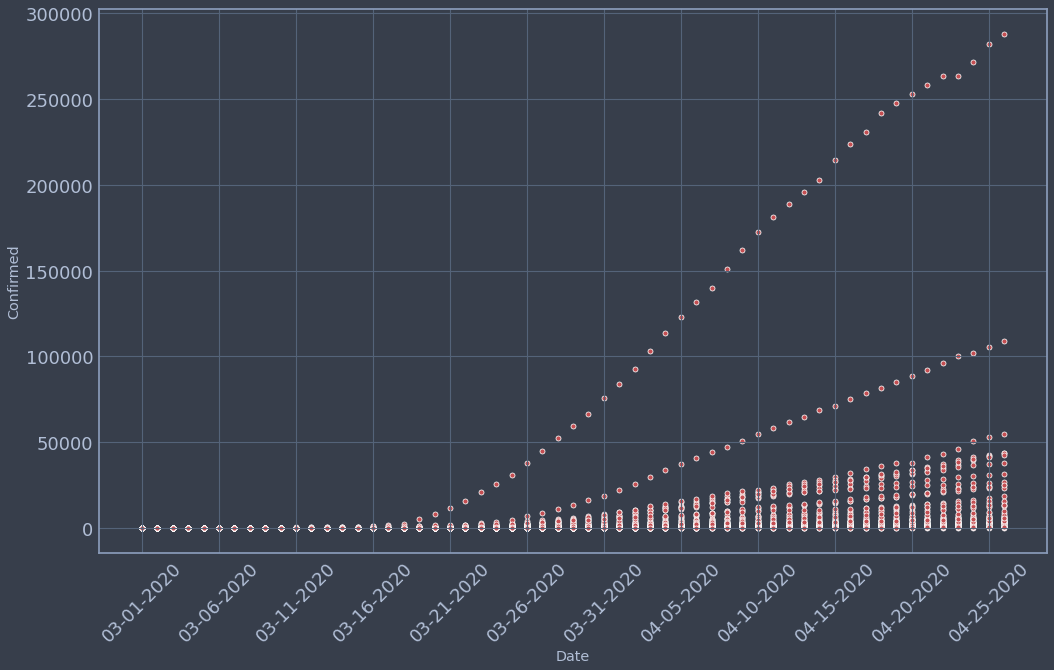

In [9]:
dates = np.ravel([[i] * len(pre.states) for i in pre.states.columns.levels[0][:-2]])
confirmed = [j for k in pre.states.columns.levels[0][:-2] for j in pre.states[k]['Confirmed']]
recovered = [j for k in pre.states.columns.levels[0][:-2] for j in pre.states[k]['Recovered']]
deaths = [j for k in pre.states.columns.levels[0][:-2] for j in pre.states[k]['Deaths']]

scatter = pd.DataFrame({'Date': dates, 'Confirmed': confirmed, 'Recovered': recovered, 'Deaths': deaths })
snsfig, snsax = plt.subplots(1, figsize = (17, 10))
sns.scatterplot(ax = snsax, x = 'Date', y = 'Confirmed', data = scatter)
snsax.set_xticks(pre.cDates[::5])
snsax.set_xticklabels(pre.cDates[::5], rotation = 45)
plt.show() #'''This is the data that needs to be fitted'''

In [13]:
from pymcmcstat.MCMC import MCMC
from pymcmcstat.MCMC import DataStructure
from pymcmcstat import mcmcplot as mcp

In [16]:
timespan = np.linspace(0, len(pre.cDates), len(dates))

model = SIR(timespan, 14)

#Define cost function
def ssfunc(q, data):
    y = data.ydata[0]
    beta, gamma, N, S, I, R = q
    ymodel = model.runmodel(beta, gamma, N, S, I, R)
    res = ymodel[1] - y
    return (res**2).sum()
#invoke module
mcmcstat = MCMC()
mcdata = DataStructure() #Just doing this for the sake of following proper format
mcmcstat.data.add_data_set(x = timespan, y = confirmed)

#apply cost function
mcmcstat.model_settings.define_model_settings(sos_function = ssfunc)

#simulation options. Using DRAM method
mcmcstat.simulation_options.define_simulation_options(
    nsimu = 10.0e3, 
    updatesigma = True,
    method = 'dram',
    adaptint = 100,
    verbosity = 1,
    waitbar = 1)

mcmcstat.parameters.add_model_parameter(
    name = 'beta',
    theta0 = 0.01,
    minimum = 0.00001,
    maximum = 0.5)

mcmcstat.parameters.add_model_parameter(
    name = 'gamma',
    theta0 = 0.01,
    minimum = 0.001,
    maximum = 0.5/2.1)

'''Population and initial conditions, these are fixed.'''
N, S, I = census['Population'].sum()/len(pre.states), census['Population'].sum()/len(pre.states) - 1, 1
R = 0
mcmcstat.parameters.add_model_parameter(
    name = 'N',
    theta0 = N,
    sample = False)

mcmcstat.parameters.add_model_parameter(
    name = 'S',
    theta0 = S,
    sample = False)

mcmcstat.parameters.add_model_parameter(
    name = 'I',
    theta0 = I,
    sample = False)

mcmcstat.parameters.add_model_parameter(
    name = 'R',
    theta0 = R,
    sample = False)

mcmcstat.run_simulation()


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
      beta:  1.00e-02 [ 1.00e-05,      0.50] N( 0.00e+00,      inf)
     gamma:  1.00e-02 [ 1.00e-03,      0.24] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 10000 of 10000 complete in 1336.9 sec



------------------------------
name      :       mean        std     MC_err        tau     geweke
beta      :     0.1854     0.1130     0.0045     7.1103     0.9028
gamma     :     0.1343     0.0670     0.0029     7.0011     0.9892
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 38.32%
Stage 2: 45.75%
Net    : 84.07% -> 8407/10000
---------------
Chain provided:
Net    : 83.22% -> 4161/5000
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------
Acceptance rate:  84.07%
Model Evaluations: 16168


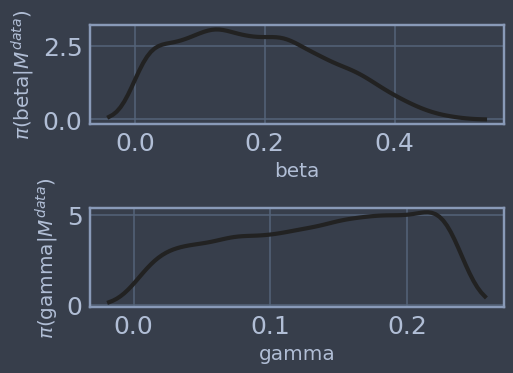

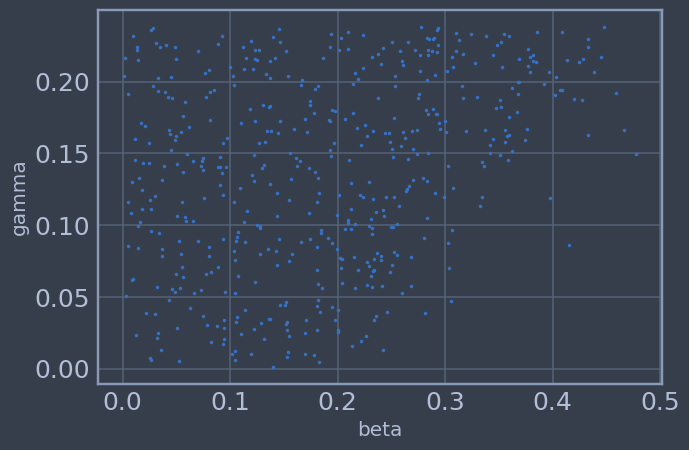

In [22]:
mcmcresults = mcmcstat.simulation_results.results
burnin = int(mcmcresults['nsimu']/2)

#Statistics
chain = mcmcresults['chain']
s2chain = mcmcresults['s2chain']
sschain = mcmcresults['sschain']
names = mcmcresults['names']
mcmcstat.chainstats(chain[burnin:,:], mcmcresults)
print('Acceptance rate: {:6.4}%'.format(100*(1 - mcmcresults['total_rejected'])))
print('Model Evaluations: {}'.format(mcmcresults['nsimu'] - mcmcresults['iacce'][0] + mcmcresults['nsimu']))

fig = mcp.plot_density_panel(chain[burnin:,:], names)
f = mcp.plot_pairwise_correlation_panel(chain[burnin:,:], names)

Above looks pretty bad: Likelihood assumptions are probably very wrong.
There might be better options out there, but this is above my skill sets. Using parameter values found above to project. 


**Initial Conditions of projection**

- Basic state projection has an average population of about 6 millions (US pop / 50 states)

- Susceptible population is the average population - (latest confirmed number / 50 states) - Removed

- Removed is sum of (current recovered + current deaths) / 50 states

- This projection assumes **ABSOLUTELY NO QUARANTINE MEASURES WERE ENFORCED**.

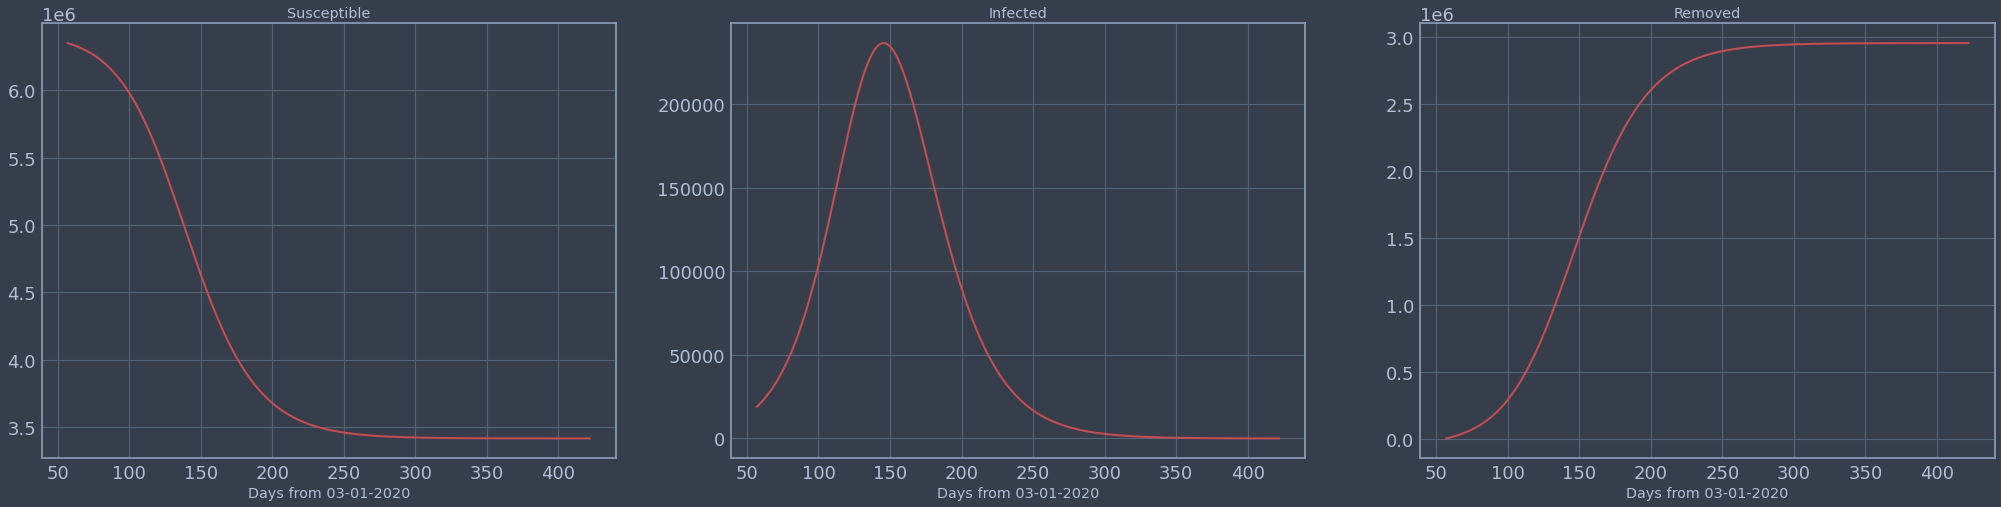

In [18]:
#difference from first date to last day
ddiff = abs((dt.strptime(pre.cDates[0], '%m-%d-%Y') - dt.strptime(pre.cDates[-1], '%m-%d-%Y')).days)
pbeta, pgamma = mcmcresults['mean'][0], mcmcresults['mean'][1]
#Projecting 360 days, fingers crossed
ptimespan = np.linspace(ddiff, ddiff + 365, 365 * len(pre.states))
model = SIR(ptimespan, 14)
#define current susceptible, infected, removed, from scatter
cconfirmed = pre.statsPerCountry('US').loc[pre.cDates[-1]]['Confirmed']/len(pre.states)
cremoved = (pre.statsPerCountry('US').loc[pre.cDates[-1]]['Recovered'] + pre.statsPerCountry('US').loc[pre.cDates[-1]]['Deaths']) / len(pre.states)
csus = S - cconfirmed - cremoved


projection = model.runmodel(pbeta, pgamma, N, csus, cconfirmed, cremoved)

pfig, pax = plt.subplots(1, 3, figsize = (35, 8))
pax[0].plot(ptimespan, projection[0])
pax[0].set(title = 'Susceptible', xlabel = 'Days from 03-01-2020')
pax[1].plot(ptimespan, projection[1])
pax[1].set(title = 'Infected', xlabel = 'Days from 03-01-2020')
pax[2].plot(ptimespan, projection[2])
pax[2].set(title = 'Removed', xlabel = 'Days from 03-01-2020')
plt.show()